In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from keras import layers
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')
import collections
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from keras import initializers
from keras.datasets import mnist
from tensorflow import keras
import tensorflow as tf
import itertools
from keras import backend as K
import time
sed = 2022
import random

# Problem 1 ------ Perceptron
### (1)

In [2]:
# create function
def generate_data(length,seed):
    np.random.seed(seed)
    x_1 = np.expand_dims(np.random.random(length),axis = 1)
    x_2 = np.expand_dims(np.random.random(length),axis = 1)
    df_1 = pd.DataFrame(np.concatenate([x_1,x_2],axis = 1)).rename({0:'x_1',1:'x_2'},axis = 1)
    df_1['y'] = (df_1['x_1'] > df_1['x_2']).astype(int)
    df_1['y'][df_1['y'] == 0] = -1
    return df_1

def train(df,seed,a,lr,epoch):
    # initialize weights
    np.random.seed(seed)
    w_1 = np.random.rand(1)
    w_2 = np.random.rand(1)
    for e in range(epoch):
        for i in range(len(df)):
            # forward
            y_hat = df.iloc[i,2] * (df.iloc[i,0]*w_1 + df.iloc[i,1]*w_2)
            loss = max(0,a-y_hat)
             # backward
            if loss > 0:
                gradient_w1 = -1 * df.iloc[i,2] * df.iloc[i,0] 
                gradient_w2 = -1 * df.iloc[i,2] * df.iloc[i,1]
                w_1 -= lr * gradient_w1
                w_2 -= lr * gradient_w2
            else:
                pass
             
    def predict_func(x1,x2):
        return 1 if w_1*x1 + w_2*x2 > 0 else -1
    return predict_func, (w_1, w_2)

In [3]:
# Train model
a = 0
df_1_train = generate_data(20,sed)
preceptron, weights = train(df_1_train,sed,a,0.1,1000)
print(weights)
# get test accuracy
df_1_test = generate_data(1000,sed)
pred = []
for i in range(len(df_1_test)):
    pred.append(preceptron(df_1_test.iloc[i,0],df_1_test.iloc[i,1]))
df_1_result = pd.concat([df_1_test,pd.DataFrame(pred).rename({0:'y_pred'},axis = 1)],axis = 1)
df_1_result['AUC'] = df_1_result['y'] == df_1_result['y_pred']
Auc_count = sum(df_1_result['AUC'])
print('Accuracy for this preceptron is: '+ str(Auc_count/1000))

(array([0.09828205]), array([-0.09308899]))
Accuracy for this preceptron is: 0.978


### (2) hinge loss

In [4]:
# Train model
a = 1
df_2_train = generate_data(20,sed)
preceptron_2, weights = train(df_2_train,sed,a,0.1,1000)
print(weights)
# get test accuracy
df_2_test = generate_data(1000,sed)
pred = []
for i in range(len(df_2_test)):
    pred.append(preceptron_2(df_2_test.iloc[i,0],df_2_test.iloc[i,1]))
df_2_result = pd.concat([df_2_test,pd.DataFrame(pred).rename({0:'y_pred'},axis = 1)],axis = 1)
df_2_result['AUC'] = df_2_result['y'] == df_2_result['y_pred']
Auc_count = sum(df_2_result['AUC'])
print('Accuracy for this preceptron is: '+ str(Auc_count/1000))

(array([12.80079885]), array([-11.97284392]))
Accuracy for this preceptron is: 0.971


### (3)

- First case gives me a better accuracy.
- It's because in the first case, we only update the weights when we get a wrong prediction, so that our weights will only update towards a direction to minmize the classfication loss. However in the second case, when $0<y(\bar{W} ·\bar{X}) <1$ even though we get a correct prediction, we still have to adjust our weights and the gradient gained by the hindge loss is not always helpful in the classfication

### (4)
- **When the data set is evenly distributed along and close to the true decision boundary** will we gain a stable result of classification of the same 1000 test instances.

# Problem 2 ------------ Weight Initialization, Dead Neurons, Leaky ReLU
### (1)

In [5]:
# copy the functions need from the github files
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras import backend as K

from matplotlib import pyplot as plt
from matplotlib import rcParamsDefault


def grid_axes_it(n_plots, n_cols=3, enumerate=False, fig=None):
    """
    Iterate through Axes objects on a grid with n_cols columns and as many
    rows as needed to accommodate n_plots many plots.
    Args:
        n_plots: Number of plots to plot onto figure.
        n_cols: Number of columns to divide the figure into.
        fig: Optional figure reference.
    Yields:
        n_plots many Axes objects on a grid.
    """
    n_rows = n_plots / n_cols + int(n_plots % n_cols > 0)

    if not fig:
        default_figsize = rcParamsDefault['figure.figsize']
        fig = plt.figure(figsize=(
            default_figsize[0] * n_cols,
            default_figsize[1] * n_rows
        ))

    for i in range(1, n_plots + 1):
        ax = plt.subplot(n_rows, n_cols, i)
        yield ax


def create_mlp_model(
    n_hidden_layers,
    dim_layer,
    input_shape,
    n_classes,
    kernel_initializer,
    bias_initializer,
    activation,
):
    """Create Multi-Layer Perceptron with given parameters."""
    model = Sequential()
    model.add(Dense(dim_layer, input_shape=input_shape, kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer))
    for i in range(n_hidden_layers):
        model.add(Dense(dim_layer, activation=activation, kernel_initializer=kernel_initializer,
                        bias_initializer=bias_initializer))
    model.add(Dense(n_classes, activation='softmax', kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer))
    return model


def create_cnn_model(input_shape, num_classes, kernel_initializer='glorot_uniform',
                     bias_initializer='zeros'):
    """Create CNN model similar to
       https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py."""
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,
                     kernel_initializer=kernel_initializer,
                     bias_initializer=bias_initializer))
    model.add(Conv2D(64, (3, 3), activation='relu',
                     kernel_initializer=kernel_initializer,
                     bias_initializer=bias_initializer))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu',
                    kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax',
                    kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer))
    return model


def compile_model(model):
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.RMSprop(),
                  metrics=['accuracy'])
    return model


def get_init_id(init):
    """
    Returns string ID summarizing initialization scheme and its parameters.
    Args:
        init: Instance of some initializer from keras.initializers.
    """
    try:
        init_name = str(init).split('.')[2].split(' ')[0]
    except:
        init_name = str(init).split(' ')[0].replace('.', '_')

    param_list = []
    config = init.get_config()
    for k, v in config.items():
        if k == 'seed':
            continue
        param_list.append('{k}-{v}'.format(k=k, v=v))
    init_params = '__'.join(param_list)

    return '|'.join([init_name, init_params])


def get_activations(model, x, mode=0.0):
    """Extract activations with given model and input vector x."""
    outputs = [layer.output for layer in model.layers]
    activations = K.function([model.input], outputs)
    output_elts = activations([x])
    return output_elts


class LossHistory(keras.callbacks.Callback):
    """A custom keras callback for recording losses during network training."""

    def on_train_begin(self, logs={}):
        self.losses = []
        self.epoch_losses = []
        self.epoch_val_losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

    def on_epoch_end(self, epoch, logs={}):
        self.epoch_losses.append(logs.get('loss'))
        self.epoch_val_losses.append(logs.get('val_loss'))

### Relu Activation

2022-10-11 23:17:21.761996: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


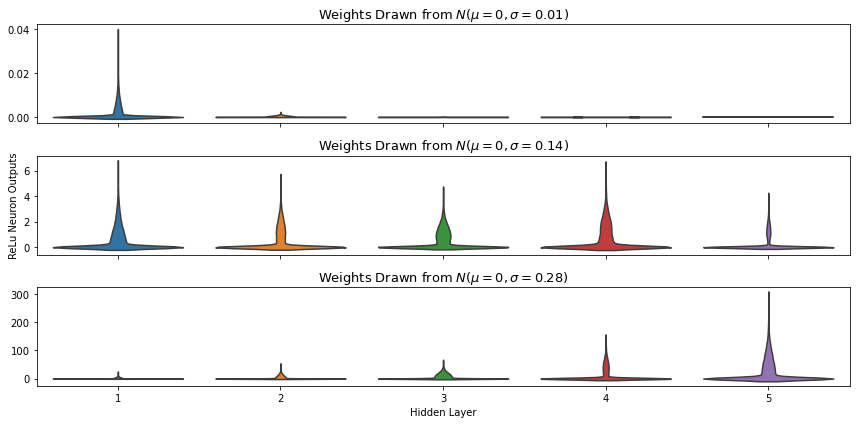

In [6]:
# copy code from plot_activation_layers.py file

seed = 10

# Number of points to plot
n_train = 1000
n_test = 100
n_classes = 10

# Network params
n_hidden_layers = 5
dim_layer = 100
batch_size = n_train
epochs = 12

# Load and prepare MNIST dataset.
n_train = 60000
n_test = 10000

(x_train, y_train), (x_test, y_test) = mnist.load_data()
num_classes = len(np.unique(y_test))
data_dim = 28 * 28

x_train = x_train.reshape(60000, 784).astype('float32')[:n_train]
x_test = x_test.reshape(10000, 784).astype('float32')[:n_train]
x_train /= 255
x_test /= 255

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Run the data through a few MLP models and save the activations from
# each layer into a Pandas DataFrame.
rows = []
sigmas = [0.01, 0.14, 0.28]
for stddev in sigmas:
    init = initializers.RandomNormal(mean=0.0, stddev=stddev, seed=seed)
    activation = 'relu'

    model = create_mlp_model(
        n_hidden_layers,
        dim_layer,
        (data_dim,),
        n_classes,
        init,
        'zeros',
        activation
    )
    compile_model(model)
    output_elts = get_activations(model, x_test)
    n_layers = len(model.layers)
    i_output_layer = n_layers - 1

    for i, out in enumerate(output_elts[:-1]):
        if i > 0 and i != i_output_layer:
            for out_i in out.ravel()[::20]:
                rows.append([i, stddev, out_i])

df = pd.DataFrame(rows, columns=['Hidden Layer', 'Standard Deviation', 'Output'])

# Plot previously saved activations from the 5 hidden layers
# using different initialization schemes.
fig = plt.figure(figsize=(12, 6))
axes = grid_axes_it(len(sigmas), 1, fig=fig)
for sig in sigmas:
    ax = next(axes)
    ddf = df[df['Standard Deviation'] == sig]
    sns.violinplot(x='Hidden Layer', y='Output', data=ddf, ax=ax, scale='count', inner=None)

    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.set_title('Weights Drawn from $N(\mu = 0, \sigma = {%.2f})$' % sig, fontsize=13)

    if sig == sigmas[1]:
        ax.set_ylabel("ReLu Neuron Outputs")
    if sig != sigmas[-1]:
        ax.set_xticklabels(())
    else:
        ax.set_xlabel("Hidden Layer")

plt.tight_layout()
plt.show()

### sigmoid activation

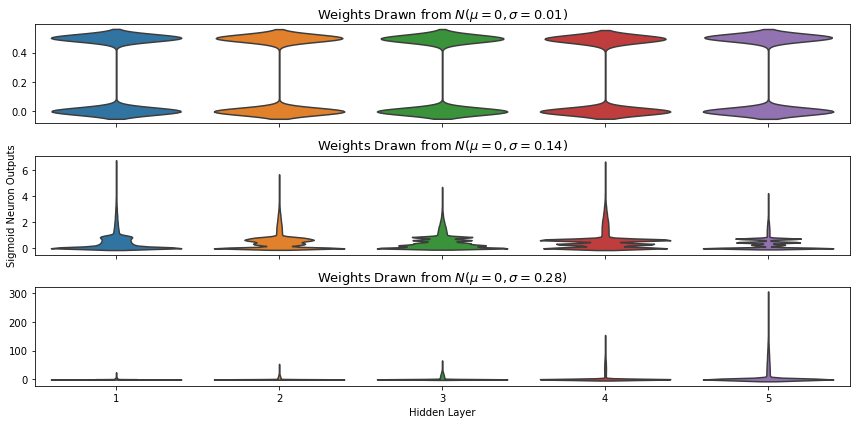

In [7]:
sigmas = [0.01, 0.14, 0.28]
for stddev in sigmas:
    init = initializers.RandomNormal(mean=0.0, stddev=stddev, seed=seed)
    activation = 'sigmoid'

    model = create_mlp_model(
        n_hidden_layers,
        dim_layer,
        (data_dim,),
        n_classes,
        init,
        'zeros',
        activation
    )
    compile_model(model)
    output_elts = get_activations(model, x_test)
    n_layers = len(model.layers)
    i_output_layer = n_layers - 1

    for i, out in enumerate(output_elts[:-1]):
        if i > 0 and i != i_output_layer:
            for out_i in out.ravel()[::20]:
                rows.append([i, stddev, out_i])

df = pd.DataFrame(rows, columns=['Hidden Layer', 'Standard Deviation', 'Output'])

# Plot previously saved activations from the 5 hidden layers
# using different initialization schemes.
fig = plt.figure(figsize=(12, 6))
axes = grid_axes_it(len(sigmas), 1, fig=fig)
for sig in sigmas:
    ax = next(axes)
    ddf = df[df['Standard Deviation'] == sig]
    sns.violinplot(x='Hidden Layer', y='Output', data=ddf, ax=ax, scale='count', inner=None)

    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.set_title('Weights Drawn from $N(\mu = 0, \sigma = {%.2f})$' % sig, fontsize=13)

    if sig == sigmas[1]:
        ax.set_ylabel("Sigmoid Neuron Outputs")
    if sig != sigmas[-1]:
        ax.set_xticklabels(())
    else:
        ax.set_xlabel("Hidden Layer")

plt.tight_layout()
plt.show()

### Tanh activation

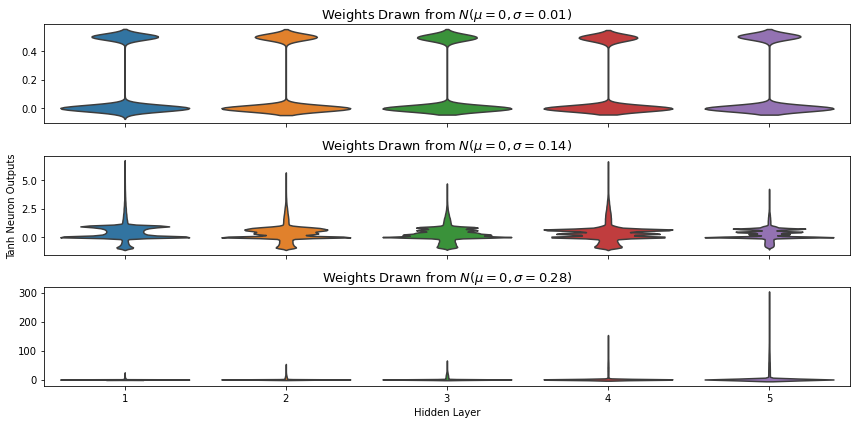

In [8]:
sigmas = [0.01, 0.14, 0.28]
for stddev in sigmas:
    init = initializers.RandomNormal(mean=0.0, stddev=stddev, seed=seed)
    activation = 'tanh'

    model = create_mlp_model(
        n_hidden_layers,
        dim_layer,
        (data_dim,),
        n_classes,
        init,
        'zeros',
        activation
    )
    compile_model(model)
    output_elts = get_activations(model, x_test)
    n_layers = len(model.layers)
    i_output_layer = n_layers - 1

    for i, out in enumerate(output_elts[:-1]):
        if i > 0 and i != i_output_layer:
            for out_i in out.ravel()[::20]:
                rows.append([i, stddev, out_i])

df = pd.DataFrame(rows, columns=['Hidden Layer', 'Standard Deviation', 'Output'])

# Plot previously saved activations from the 5 hidden layers
# using different initialization schemes.
fig = plt.figure(figsize=(12, 6))
axes = grid_axes_it(len(sigmas), 1, fig=fig)
for sig in sigmas:
    ax = next(axes)
    ddf = df[df['Standard Deviation'] == sig]
    sns.violinplot(x='Hidden Layer', y='Output', data=ddf, ax=ax, scale='count', inner=None)

    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.set_title('Weights Drawn from $N(\mu = 0, \sigma = {%.2f})$' % sig, fontsize=13)

    if sig == sigmas[1]:
        ax.set_ylabel("Tanh Neuron Outputs")
    if sig != sigmas[-1]:
        ax.set_xticklabels(())
    else:
        ax.set_xlabel("Hidden Layer")

plt.tight_layout()
plt.show()

### GlorotNormal initialization

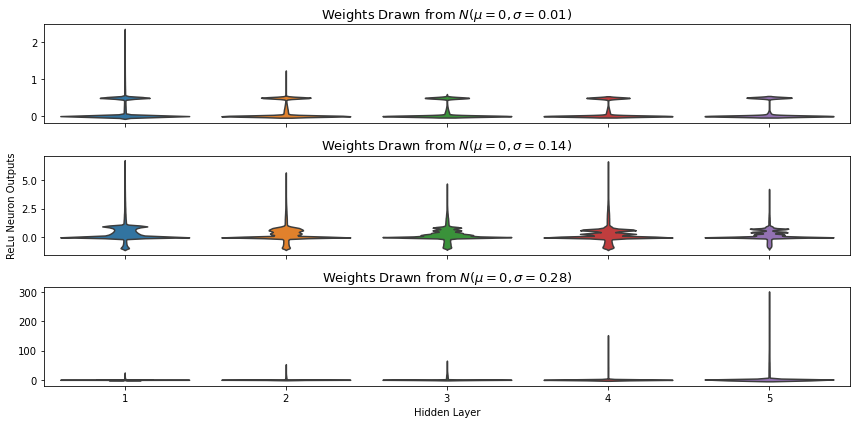

In [9]:
sigmas = [0.01, 0.14, 0.28]
for stddev in sigmas:
    init = initializers.glorot_normal(seed = seed)
    activation = 'relu'

    model = create_mlp_model(
        n_hidden_layers,
        dim_layer,
        (data_dim,),
        n_classes,
        init,
        'zeros',
        activation
    )
    compile_model(model)
    output_elts = get_activations(model, x_test)
    n_layers = len(model.layers)
    i_output_layer = n_layers - 1

    for i, out in enumerate(output_elts[:-1]):
        if i > 0 and i != i_output_layer:
            for out_i in out.ravel()[::20]:
                rows.append([i, stddev, out_i])

df = pd.DataFrame(rows, columns=['Hidden Layer', 'Standard Deviation', 'Output'])

# Plot previously saved activations from the 5 hidden layers
# using different initialization schemes.
fig = plt.figure(figsize=(12, 6))
axes = grid_axes_it(len(sigmas), 1, fig=fig)
for sig in sigmas:
    ax = next(axes)
    ddf = df[df['Standard Deviation'] == sig]
    sns.violinplot(x='Hidden Layer', y='Output', data=ddf, ax=ax, scale='count', inner=None)

    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.set_title('Weights Drawn from $N(\mu = 0, \sigma = {%.2f})$' % sig, fontsize=13)

    if sig == sigmas[1]:
        ax.set_ylabel("ReLu Neuron Outputs")
    if sig != sigmas[-1]:
        ax.set_xticklabels(())
    else:
        ax.set_xlabel("Hidden Layer")

plt.tight_layout()
plt.show()

### He initialization 

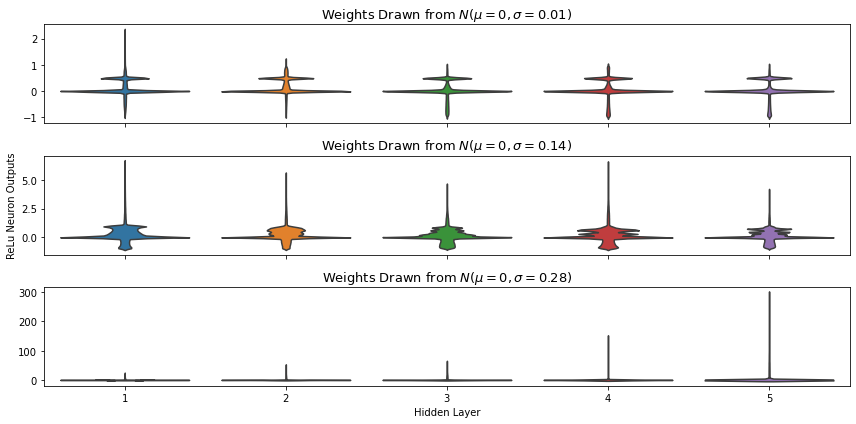

In [10]:
sigmas = [0.01, 0.14, 0.28]
for stddev in sigmas:
    init = initializers.HeNormal(seed=seed)
    activation = 'tanh'

    model = create_mlp_model(
        n_hidden_layers,
        dim_layer,
        (data_dim,),
        n_classes,
        init,
        'zeros',
        activation
    )
    compile_model(model)
    output_elts = get_activations(model, x_test)
    n_layers = len(model.layers)
    i_output_layer = n_layers - 1

    for i, out in enumerate(output_elts[:-1]):
        if i > 0 and i != i_output_layer:
            for out_i in out.ravel()[::20]:
                rows.append([i, stddev, out_i])

df = pd.DataFrame(rows, columns=['Hidden Layer', 'Standard Deviation', 'Output'])

# Plot previously saved activations from the 5 hidden layers
# using different initialization schemes.
fig = plt.figure(figsize=(12, 6))
axes = grid_axes_it(len(sigmas), 1, fig=fig)
for sig in sigmas:
    ax = next(axes)
    ddf = df[df['Standard Deviation'] == sig]
    sns.violinplot(x='Hidden Layer', y='Output', data=ddf, ax=ax, scale='count', inner=None)

    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.set_title('Weights Drawn from $N(\mu = 0, \sigma = {%.2f})$' % sig, fontsize=13)

    if sig == sigmas[1]:
        ax.set_ylabel("ReLu Neuron Outputs")
    if sig != sigmas[-1]:
        ax.set_xticklabels(())
    else:
        ax.set_xlabel("Hidden Layer")

plt.tight_layout()
plt.show()

- Here in order to see the effect clear I use the $[0.01,0.14,0.28]$ As my sigmas, and as shown on the above plots, as the $\sigma$ close to zero, we will face the Vanishing gradient since for front layers the gradient are close to 0 so that they're not updating.
- Comparied with relu, using simoid and Tanh is less likly to encounter Vanishing gradient.
- After change the initializer into GlorotNormal, the Vanishing gradient for relu activation is imporved.
- After change the initializer into Heinitialization, the Vanishing gradient for relu activation is imporved.

### (2)

In [137]:
collapus_count = 0
for i in range(1000):
    x = np.random.uniform(-np.sqrt(7),np.sqrt(7),3000)
    y = np.abs(x)
    init = initializers.HeNormal(seed = sed)
    model_2 = keras.Sequential([layers.Dense(2, activation="relu",input_shape = (1,),
                                             kernel_initializer=init,use_bias=True),
                             layers.Dense(2, activation="relu",kernel_initializer=init,use_bias=True),
                             layers.Dense(2, activation="relu",kernel_initializer=init,use_bias=True),
                             layers.Dense(2, activation="relu",kernel_initializer=init,use_bias=True),
                             layers.Dense(2, activation="relu",kernel_initializer=init,use_bias=True),
                             layers.Dense(2, activation="relu",kernel_initializer=init,use_bias=True),
                             layers.Dense(2, activation="relu",kernel_initializer=init,use_bias=True),
                             layers.Dense(2, activation="relu",kernel_initializer=init,use_bias=True),
                             layers.Dense(2, activation="relu",kernel_initializer=init,use_bias=True),
                             layers.Dense(2, activation="relu",kernel_initializer=init,use_bias=True),
                             layers.Dense(1,use_bias=False)])
    model_2.compile(loss='mean_squared_error', optimizer='adam', metrics=['MSE'])
    model_2.fit(x=x,y=y, epochs=1, batch_size=64, verbose=0)
    pred = model_2.predict(x)
    if len(np.unique(pred)) == 1 and np.unique(pred)[0]==0:
        collapus_count+=1

In [138]:
print('The collapsed models are: ' + str(collapus_count)+' ,So the proportion is close to 90% as reported in the paper')

The collapsed models are: 91 ,So the proportion is close to 90% as reported in the paper


### (3)

In [139]:
leakyrelu = tf.keras.layers.LeakyReLU(alpha=0.01)
collapus_count_leak_relu = 0
for i in range(1000):
    x = np.random.uniform(-np.sqrt(7),np.sqrt(7),3000)
    y = np.abs(x)
    init = initializers.HeNormal(seed = sed)
    model_3 = keras.Sequential([layers.Dense(2, activation=leakyrelu,input_shape = (1,),
                                             kernel_initializer=init,use_bias=True),
                             layers.Dense(2, activation=leakyrelu,kernel_initializer=init,use_bias=True),
                             layers.Dense(2, activation=leakyrelu,kernel_initializer=init,use_bias=True),
                             layers.Dense(2, activation=leakyrelu,kernel_initializer=init,use_bias=True),
                             layers.Dense(2, activation=leakyrelu,kernel_initializer=init,use_bias=True),
                             layers.Dense(2, activation=leakyrelu,kernel_initializer=init,use_bias=True),
                             layers.Dense(2, activation=leakyrelu,kernel_initializer=init,use_bias=True),
                             layers.Dense(2, activation=leakyrelu,kernel_initializer=init,use_bias=True),
                             layers.Dense(2, activation=leakyrelu,kernel_initializer=init,use_bias=True),
                             layers.Dense(2, activation=leakyrelu,kernel_initializer=init,use_bias=True),
                             layers.Dense(1,use_bias=False)])
    model_3.compile(loss='mean_squared_error', optimizer='adam', metrics=['MSE'])
    model_3.fit(x=x,y=y, epochs=1, batch_size=64, verbose=0)
    pred = model_3.predict(x)
    if len(np.unique(pred)) == 1 and np.unique(pred)[0]==0:
        collapus_count_leak_relu+=1

In [140]:
print('The collapsed models are: ' + str(collapus_count_leak_relu)+' , there is no collapse after using leakeyrelu!')

The collapsed models are: 0 , there is no collapse after using leakeyrelu!


# Problem 3 ------- Batch Normalization, Dropout, MNIST

### (1)

##### co-adaptation
- As is stated in Hinton's paper **The ability of a set of genes to be able to work well with another random set of genes makes them more robust. Since a gene cannot rely on a large set of partners to be present at all times, it must learn to do something useful on its own or in collaboration with a small number of other genes.** In the neural network, neurons just works like gene in sexual reproduction. When adding dropout, the complex co-adaptation is reduced thus making neural network more robust and have better performance on test datasets.

##### covariance-shift
-  Covariance-shift is defined as **the distribution of each layer’s inputs changes during training, as the parameters of the previous layers change.**. However by using the regularization like Batch Normalization, we can actually let input of each layer transform into standard normal distribution, thus let all hidden layers have the same distribution of input, and address the covariance-shift problem.


### (2)

In [231]:
# preprocess data
(x_train, y_train), (x_val, y_val) = mnist.load_data()
x_train = np.expand_dims(x_train, axis = 3)
x_val = np.expand_dims(x_val, axis = 3)
mean_train = np.mean(x_train)
var_train = np.var(x_train)

# define Lenet-5 and add BNlayer and train the model
model_3_2 = tf.keras.models.Sequential([
        tf.keras.layers.Normalization(axis=-1, mean=mean_train, variance=var_train),
        tf.keras.layers.Conv2D(6, kernel_size=5, strides = 1,input_shape = (28,28,1),activation = 'tanh'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.AveragePooling2D(pool_size =(2,2), strides = 2),
        tf.keras.layers.Conv2D(16, kernel_size = 5, strides = 1, activation = 'tanh'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.AveragePooling2D(pool_size = (2,2), strides = 2),
        tf.keras.layers.Conv2D(120, kernel_size = 2, strides = 2, activation = 'tanh'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(84, activation = 'tanh'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(10, activation = 'softmax'),
    ])

model_3_2.compile(loss = 'sparse_categorical_crossentropy',optimizer = 'adam', metrics = ['accuracy'])
history_3_2 = model_3_2.fit(x_train, y_train, epochs = 10, batch_size = 64, validation_data=(x_val, y_val))

Epoch 1/10
938/938 [==============================] - 14s 14ms/step - loss: 0.1688 - accuracy: 0.9500 - val_loss: 0.0709 - val_accuracy: 0.9774
Epoch 2/10
938/938 [==============================] - 13s 14ms/step - loss: 0.0634 - accuracy: 0.9811 - val_loss: 0.0531 - val_accuracy: 0.9806
Epoch 3/10
938/938 [==============================] - 13s 14ms/step - loss: 0.0472 - accuracy: 0.9852 - val_loss: 0.0480 - val_accuracy: 0.9851
Epoch 4/10
938/938 [==============================] - 13s 14ms/step - loss: 0.0419 - accuracy: 0.9870 - val_loss: 0.0412 - val_accuracy: 0.9863
Epoch 5/10
938/938 [==============================] - 13s 14ms/step - loss: 0.0369 - accuracy: 0.9882 - val_loss: 0.0383 - val_accuracy: 0.9871
Epoch 6/10
938/938 [==============================] - 13s 14ms/step - loss: 0.0332 - accuracy: 0.9890 - val_loss: 0.0347 - val_accuracy: 0.9885
Epoch 7/10
938/938 [==============================] - 14s 14ms/step - loss: 0.0302 - accuracy: 0.9905 - val_loss: 0.0460 - val_accuracy:

[Text(0.5, 1.0, 'Std_norm_input + BN_hidden')]

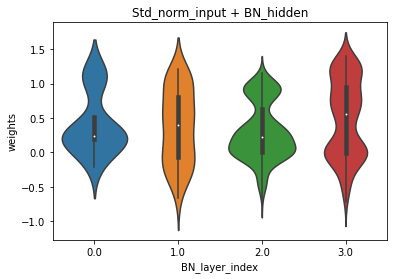

In [232]:
# get parametres in BN_layer
BN_index = [2,5,8,11]
BN_parameters_df = None
BN_index_count = 0
for i in BN_index:
    weight = model_3_2.layers[i].get_weights()
    weight = np.concatenate(weight)
    index = BN_index_count*np.ones_like(weight)
    weight = np.expand_dims(weight,axis = 1)
    index = np.expand_dims(index,axis = 1)
    weight = np.concatenate([weight,index],axis = 1)
    weight = pd.DataFrame(weight)
    BN_index_count+=1
    if BN_parameters_df is not None:
        BN_parameters_df = pd.concat([BN_parameters_df,weight],axis = 0)
    else:
        BN_parameters_df = weight
BN_parameters_df = BN_parameters_df.rename({0:'weights',1:'BN_layer_index'},axis = 1)
sns.violinplot(x = BN_parameters_df['BN_layer_index'], 
               y = BN_parameters_df['weights']).set(title = 'Std_norm_input + BN_hidden')

### (3)

In [233]:
# define Lenet-5 and add BNlayer and train the model
model_3_3 = tf.keras.models.Sequential([
        tf.keras.layers.BatchNormalization(input_shape = (28,28,1)),
        tf.keras.layers.Conv2D(6, kernel_size=5, strides = 1,activation = 'tanh'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.AveragePooling2D(pool_size =(2,2), strides = 2),
        tf.keras.layers.Conv2D(16, kernel_size = 5, strides = 1, activation = 'tanh'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.AveragePooling2D(pool_size = (2,2), strides = 2),
        tf.keras.layers.Conv2D(120, kernel_size = 2, strides = 2, activation = 'tanh'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(84, activation = 'tanh'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(10, activation = 'softmax'),
    ])

model_3_3.compile(loss = 'sparse_categorical_crossentropy',optimizer = 'adam', metrics = ['accuracy'])
history_3_3 = model_3_3.fit(x_train, y_train, epochs = 10, batch_size = 64, validation_data=(x_val, y_val))

Epoch 1/10
938/938 [==============================] - 16s 16ms/step - loss: 0.1576 - accuracy: 0.9532 - val_loss: 0.0611 - val_accuracy: 0.9808
Epoch 2/10
938/938 [==============================] - 15s 16ms/step - loss: 0.0620 - accuracy: 0.9808 - val_loss: 0.0448 - val_accuracy: 0.9850
Epoch 3/10
938/938 [==============================] - 15s 16ms/step - loss: 0.0471 - accuracy: 0.9853 - val_loss: 0.0425 - val_accuracy: 0.9867
Epoch 4/10
938/938 [==============================] - 15s 16ms/step - loss: 0.0404 - accuracy: 0.9873 - val_loss: 0.0416 - val_accuracy: 0.9861
Epoch 5/10
938/938 [==============================] - 15s 16ms/step - loss: 0.0343 - accuracy: 0.9893 - val_loss: 0.0411 - val_accuracy: 0.9885
Epoch 6/10
938/938 [==============================] - 15s 16ms/step - loss: 0.0321 - accuracy: 0.9895 - val_loss: 0.0336 - val_accuracy: 0.9898
Epoch 7/10
938/938 [==============================] - 15s 16ms/step - loss: 0.0296 - accuracy: 0.9907 - val_loss: 0.0411 - val_accuracy:

[Text(0.5, 1.0, 'All_BN')]

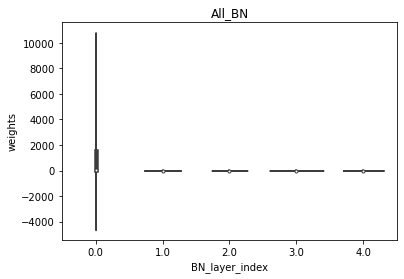

In [290]:
BN_index = [0,2,5,8,11]
BN_parameters_df = None
BN_index_count = 0
for i in BN_index:
    weight = model_3_3.layers[i].get_weights()
    weight = np.concatenate(weight)
    index = BN_index_count*np.ones_like(weight)
    weight = np.expand_dims(weight,axis = 1)
    index = np.expand_dims(index,axis = 1)
    weight = np.concatenate([weight,index],axis = 1)
    weight = pd.DataFrame(weight)
    BN_index_count+=1
    if BN_parameters_df is not None:
        BN_parameters_df = pd.concat([BN_parameters_df,weight],axis = 0)
    else:
        BN_parameters_df = weight
BN_parameters_df = BN_parameters_df.rename({0:'weights',1:'BN_layer_index'},axis = 1)
sns.violinplot(x = BN_parameters_df['BN_layer_index'], 
               y = BN_parameters_df['weights']).set(title = 'All_BN')

##### compare train/test loss

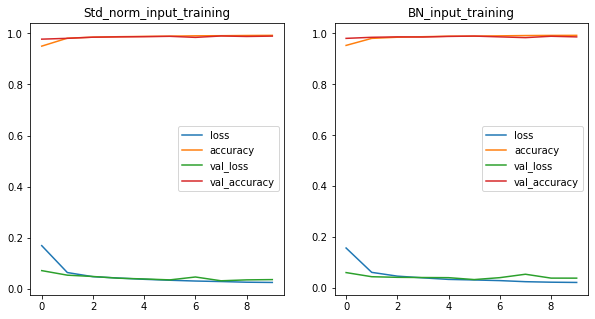

In [251]:
fig, ax = plt.subplots(1,2,figsize = (10,5))
epoch_plot = range(10)
for key in history_3_2.history.keys():
    ax[0].plot(epoch_plot,history_3_2.history[key],label = key)
    ax[0].legend()
    ax[0].set_title('Std_norm_input_training')
    
for key in history_3_3.history.keys():
    ax[1].plot(epoch_plot,history_3_3.history[key],label = key)
    ax[1].legend()
    ax[1].set_title('BN_input_training')

- According to the plot, using the BN for input didn't improve the performace significantly, on the contrary, it slightly increase the validation_loss a little bit on the 7th epoch. And also, according to the violinplot the parameters in BN layer of input and hidden layer are not in the same scale.

### (4)

In [256]:
# define Lenet-5 and add BNlayer and train the model
model_3_4 = tf.keras.models.Sequential([
        tf.keras.layers.Dropout(0.2,input_shape = (28,28,1)),
        tf.keras.layers.Conv2D(6, kernel_size=5, strides = 1,activation = 'tanh'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.AveragePooling2D(pool_size =(2,2), strides = 2),
        tf.keras.layers.Conv2D(16, kernel_size = 5, strides = 1, activation = 'tanh'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.AveragePooling2D(pool_size = (2,2), strides = 2),
        tf.keras.layers.Conv2D(120, kernel_size = 2, strides = 2, activation = 'tanh'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(84, activation = 'tanh'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation = 'softmax'),
    ])

model_3_4.compile(loss = 'sparse_categorical_crossentropy',optimizer = 'adam', metrics = ['accuracy'])
history_3_4 = model_3_3.fit(x_train, y_train, epochs = 10, batch_size = 64, validation_data=(x_val, y_val))

Epoch 1/10
938/938 [==============================] - 16s 17ms/step - loss: 0.0103 - accuracy: 0.9967 - val_loss: 0.0379 - val_accuracy: 0.9901
Epoch 2/10
938/938 [==============================] - 15s 16ms/step - loss: 0.0111 - accuracy: 0.9962 - val_loss: 0.0403 - val_accuracy: 0.9881
Epoch 3/10
938/938 [==============================] - 16s 17ms/step - loss: 0.0092 - accuracy: 0.9970 - val_loss: 0.0420 - val_accuracy: 0.9898
Epoch 4/10
938/938 [==============================] - 16s 17ms/step - loss: 0.0096 - accuracy: 0.9967 - val_loss: 0.0376 - val_accuracy: 0.9896
Epoch 5/10
938/938 [==============================] - 16s 17ms/step - loss: 0.0095 - accuracy: 0.9966 - val_loss: 0.0434 - val_accuracy: 0.9895
Epoch 6/10
938/938 [==============================] - 17s 18ms/step - loss: 0.0083 - accuracy: 0.9973 - val_loss: 0.0402 - val_accuracy: 0.9894
Epoch 7/10
938/938 [==============================] - 16s 17ms/step - loss: 0.0089 - accuracy: 0.9972 - val_loss: 0.0367 - val_accuracy:

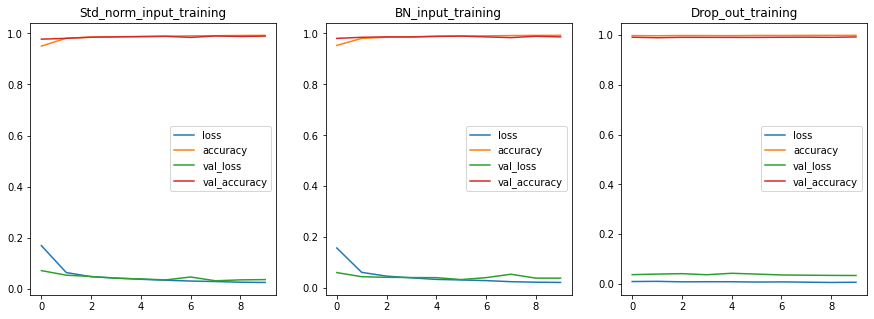

In [257]:
fig, ax = plt.subplots(1,3,figsize = (15,5))
epoch_plot = range(10)
for key in history_3_2.history.keys():
    ax[0].plot(epoch_plot,history_3_2.history[key],label = key)
    ax[0].legend()
    ax[0].set_title('Std_norm_input_training')
    
for key in history_3_3.history.keys():
    ax[1].plot(epoch_plot,history_3_3.history[key],label = key)
    ax[1].legend()
    ax[1].set_title('BN_input_training')
    
for key in history_3_4.history.keys():
    ax[2].plot(epoch_plot,history_3_4.history[key],label = key)
    ax[2].legend()
    ax[2].set_title('Drop_out_training')

- After using Dropout layer instead of BN layer, the model converged within one epoch, it trained faster, but the final accuracy and loss seems don't have a significant difference.

### (5)

In [258]:
model_3_5 = tf.keras.models.Sequential([
        tf.keras.layers.BatchNormalization(input_shape = (28,28,1)),
        tf.keras.layers.Conv2D(6, kernel_size=5, strides = 1,activation = 'tanh'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.AveragePooling2D(pool_size =(2,2), strides = 2),
        tf.keras.layers.Conv2D(16, kernel_size = 5, strides = 1, activation = 'tanh'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.AveragePooling2D(pool_size = (2,2), strides = 2),
        tf.keras.layers.Conv2D(120, kernel_size = 2, strides = 2, activation = 'tanh'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(84, activation = 'tanh'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation = 'softmax'),
    ])

model_3_5.compile(loss = 'sparse_categorical_crossentropy',optimizer = 'adam', metrics = ['accuracy'])
history_3_5 = model_3_5.fit(x_train, y_train, epochs = 10, batch_size = 64, validation_data=(x_val, y_val))

Epoch 1/10
938/938 [==============================] - 17s 17ms/step - loss: 0.5908 - accuracy: 0.8151 - val_loss: 0.1129 - val_accuracy: 0.9642
Epoch 2/10
938/938 [==============================] - 16s 17ms/step - loss: 0.2424 - accuracy: 0.9269 - val_loss: 0.0771 - val_accuracy: 0.9751
Epoch 3/10
938/938 [==============================] - 16s 17ms/step - loss: 0.1970 - accuracy: 0.9407 - val_loss: 0.0607 - val_accuracy: 0.9798
Epoch 4/10
938/938 [==============================] - 16s 17ms/step - loss: 0.1780 - accuracy: 0.9477 - val_loss: 0.0539 - val_accuracy: 0.9828
Epoch 5/10
938/938 [==============================] - 20s 22ms/step - loss: 0.1633 - accuracy: 0.9516 - val_loss: 0.0552 - val_accuracy: 0.9830
Epoch 6/10
938/938 [==============================] - 17s 18ms/step - loss: 0.1535 - accuracy: 0.9547 - val_loss: 0.0536 - val_accuracy: 0.9821
Epoch 7/10
938/938 [==============================] - 17s 18ms/step - loss: 0.1491 - accuracy: 0.9556 - val_loss: 0.0489 - val_accuracy:

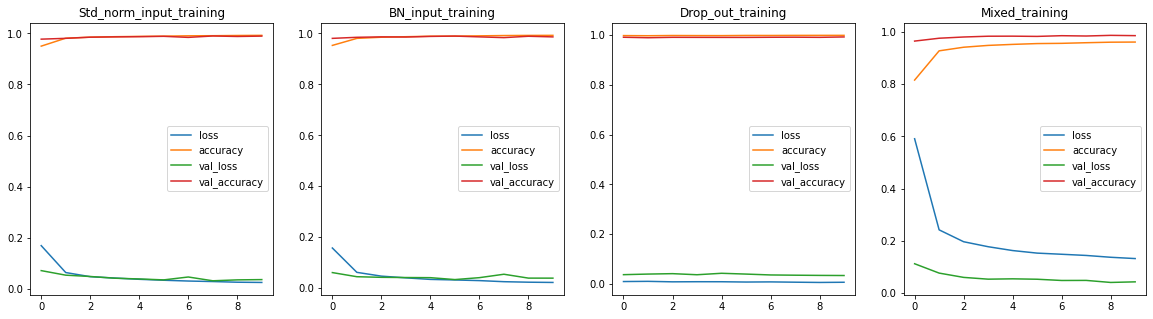

In [261]:
fig, ax = plt.subplots(1,4,figsize = (20,5))
epoch_plot = range(10)
for key in history_3_2.history.keys():
    ax[0].plot(epoch_plot,history_3_2.history[key],label = key)
    ax[0].legend()
    ax[0].set_title('Std_norm_input_training')
    
for key in history_3_3.history.keys():
    ax[1].plot(epoch_plot,history_3_3.history[key],label = key)
    ax[1].legend()
    ax[1].set_title('BN_input_training')
    
for key in history_3_4.history.keys():
    ax[2].plot(epoch_plot,history_3_4.history[key],label = key)
    ax[2].legend()
    ax[2].set_title('Drop_out_training')
    
for key in history_3_5.history.keys():
    ax[3].plot(epoch_plot,history_3_5.history[key],label = key)
    ax[3].legend()
    ax[3].set_title('Mixed_training')

- According to the above plot, After using BN and drop togather, model significantly reduces it's performance.

# Problem 4

In [23]:
# useful functions and generate data set
def eggholderfx(x_1,x_2):
    part_1 = -(x_2+47)*np.sin(np.sqrt(np.abs(x_1/2 + (x_2+47))))
    part_2 = - x_1*np.sin(np.sqrt(np.abs(x_1-(x_2+47))))
    return  part_1 + part_2
def creat_y(x_1,x_2):
    return (eggholderfx(x_1,x_2) + np.random.normal(loc = 0, scale = np.sqrt(0.3)))
np.random.seed(sed)
X = np.random.uniform(-512,512,(100000,2))
y = []
for i in X:
    x_i = creat_y(i[0],i[1])
    y.append(x_i)
y = np.array(y)

x_train, x_val, y_train, y_val = train_test_split(X,y,test_size=0.2, random_state=sed)

### (1)

In [86]:
unit_selection = [16,32,64,128,256,512]
my_sgd = tf.keras.optimizers.SGD(nesterov=True)
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
def get_layer_and_units(layer_num,unit_list):
    return_list = []
    for i in itertools.product(unit_list,repeat = layer_num):
        if sum(i) <= 512:
            return_list.append(i)
    return(return_list)

def my_create_model(unit_list):
    model = keras.models.Sequential([keras.layers.Dense(unit_list[0], input_shape = (2,),activation = 'relu')])
    for i,unit in enumerate(unit_list):
        if i != 0:
            model.add(keras.layers.Dense(unit, activation = 'relu'))
            model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(1))
    return model

def problem4_experiment(layer, epoch_num):
    num_of_units_one_layer = []
    rmses_one_layer = []
    num_parameters_one_layer = []
    used_time_onelayer = []
    for i in range(len(layer)):  # change layer parameters here
        model =  my_create_model(layer[i]) # change layer parameters here
        model.compile(loss = root_mean_squared_error,
                      optimizer = my_sgd,metrics=[tf.keras.metrics.RootMeanSquaredError()])

        start = time.monotonic()
        model.fit(x_train, y_train, epochs=epoch_num,batch_size = 1000, 
                  validation_data=(x_val,y_val),verbose = 0)
        end = time.monotonic()
        total_time = end-start
        rmse = np.sqrt(np.mean(np.power((model.predict(x_val).reshape(len(y_val))-y_val),2)))

        used_time_onelayer.append(total_time)
        rmses_one_layer.append(rmse)
        num_of_units_one_layer.append(sum(layer[i]))  # change layer parameters here
        num_parameters_one_layer.append(model.count_params())
        print('Finished number: '+ str(i+1)+', total number of models: '+str(len(layer)))
    return num_of_units_one_layer,rmses_one_layer,num_parameters_one_layer,used_time_onelayer 

- Here if I want to train all combinations I need to train more than 10 hours on 3070 GPU, So for two layer model and three layer model,I only sample 10 combinations form each and train total 26 models.

In [87]:
random.seed = sed
one_layer = get_layer_and_units(1,unit_selection)
two_layer = random.sample(get_layer_and_units(2,unit_selection),10)
three_layer = random.sample(get_layer_and_units(3,unit_selection),10)

In [88]:
# start training one layer model
units_one, rmse_one, num_parameters_one, used_time_one = problem4_experiment(one_layer,2000)

Finished number: 1, total number of models: 6
Finished number: 2, total number of models: 6
Finished number: 3, total number of models: 6
Finished number: 4, total number of models: 6
Finished number: 5, total number of models: 6
Finished number: 6, total number of models: 6


In [89]:
# start training two layer model
units_two, rmse_two, num_parameters_two, used_time_two = problem4_experiment(random.sample(two_layer, 10),2000)

Finished number: 1, total number of models: 10
Finished number: 2, total number of models: 10
Finished number: 3, total number of models: 10
Finished number: 4, total number of models: 10
Finished number: 5, total number of models: 10
Finished number: 6, total number of models: 10
Finished number: 7, total number of models: 10
Finished number: 8, total number of models: 10
Finished number: 9, total number of models: 10
Finished number: 10, total number of models: 10


In [90]:
# start training three layer model
units_three, rmse_three, num_parameters_three, used_time_three = problem4_experiment(random.sample(three_layer, 10),2000)

Finished number: 1, total number of models: 10
Finished number: 2, total number of models: 10
Finished number: 3, total number of models: 10
Finished number: 4, total number of models: 10
Finished number: 5, total number of models: 10
Finished number: 6, total number of models: 10
Finished number: 7, total number of models: 10
Finished number: 8, total number of models: 10
Finished number: 9, total number of models: 10
Finished number: 10, total number of models: 10


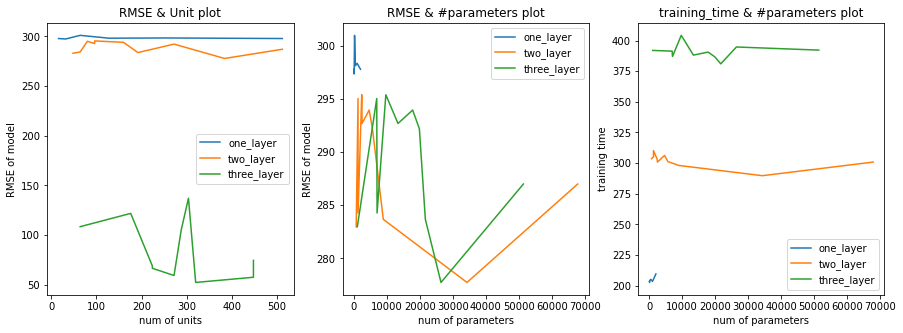

In [91]:
units_RMSE_two_sorted = np.array(sorted(zip(units_two, rmse_two), key = lambda x: x[0]))
units_RMSE_three_sorted = np.array(sorted(zip(units_three, rmse_three), key = lambda x: x[0]))
params_RMSE_two_sorted = np.array(sorted(zip(num_parameters_two, rmse_two), key = lambda x: x[0]))
params_RMSE_three_sorted = np.array(sorted(zip(num_parameters_three, rmse_three), key = lambda x: x[0]))
params_time_two_sorted = np.array(sorted(zip(num_parameters_two, used_time_two), key = lambda x: x[0]))
params_time_three_sorted = np.array(sorted(zip(num_parameters_three, used_time_three), key = lambda x: x[0]))

fig, ax = plt.subplots(1,3,figsize = (15,5))
ax[0].plot(units_one, rmse_one, label = 'one_layer')
ax[0].plot(units_RMSE_two_sorted[:,0], units_RMSE_two_sorted[:,1], label = 'two_layer')
ax[0].plot(units_RMSE_three_sorted[:,0], units_RMSE_three_sorted[:,1], label = 'three_layer')
ax[0].set_xlabel('num of units')
ax[0].set_ylabel('RMSE of model')
ax[0].set_title('RMSE & Unit plot')
ax[0].legend()

ax[1].plot(num_parameters_one, rmse_one, label = 'one_layer')
ax[1].plot(params_RMSE_two_sorted[:,0], params_RMSE_two_sorted[:,1], label = 'two_layer')
ax[1].plot(params_RMSE_three_sorted[:,0], params_RMSE_two_sorted[:,1], label = 'three_layer')
ax[1].set_xlabel('num of parameters')
ax[1].set_ylabel('RMSE of model')
ax[1].set_title('RMSE & #parameters plot')
ax[1].legend()

ax[2].plot(num_parameters_one, used_time_one, label = 'one_layer')
ax[2].plot(params_time_two_sorted[:,0], params_time_two_sorted[:,1], label = 'two_layer')
ax[2].plot(params_time_three_sorted[:,0], params_time_three_sorted[:,1], label = 'three_layer')
ax[2].set_xlabel('num of parameters')
ax[2].set_ylabel('training time')
ax[2].set_title('training_time & #parameters plot')
ax[2].legend()

- Sorry the second plot I use the wrong Y value, I should use params_RMSE_three_sorted instead of params_RMSE_two_sorted, however I don't have the time to rerun the result, Plz don't deduct score!
- Acording to the first plot, green line should below the orange line

### (2)

- According to the plots, we are excepted to have a lower RMSE when we add more parameters or units to our model
- According to the plot in the middle hand side, going deeper don't seems to always have a lower RMSE. From 1 year to 2 layer, the RMSE decreased significantly, however from 2 layers to 3 layers, the RMSE doesn't drop as excepted.
- According to the plot on the right hand side, I don't see a similiar trade off in training time. (with same layer, the training time don't have a huge variation as the num of parameters increase)